In [106]:
import pickle
with open("u_cnt1.pkl","rb") as f:
    u_cnt1 = pickle.load(f)

In [135]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        input_size = 621  # 입력 벡터 크기
        hidden_size = 256  # 은닉층 크기
        latent_size = 32  # 잠재 변수 크기
        num_categories = 621  # 이산 확률 분포의 카테고리 수
        temperature = 15  # Gumbel-Softmax relaxation의 온도 매개변수

        super(VAE, self).__init__()
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_categories = num_categories
        self.temperature = temperature

        # Encoder
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc_mean = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)

        # Decoder
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_categories)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = eps.mul(std).add_(mean)
        else:
            z = mean
        return z

    def gumbel_softmax(self, logits):
        gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits) + 1e-8) + 1e-8)
        softmax = F.softmax((logits + gumbel_noise) / self.temperature, dim=-1)
        return softmax

    def decode(self, z):
        h = F.relu(self.fc3(z))
        logits = self.fc4(h)
        probas = self.gumbel_softmax(logits)
        return probas

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mean, logvar

    def sample(self, num_samples=1):
        z = torch.randn(num_samples, self.latent_size).to("cuda:0")
        #z = torch.randn(num_samples, self.latent_size)
        probas = self.decode(z)
        return probas
model = VAE()
w = model.state_dict()
lyr_info = []
for idx, i in enumerate(w):
    lyr_info.append([])
    print(i, w[i].shape)
    for j in w[i].shape:
        lyr_info[idx].append(j)

fc1.weight torch.Size([256, 621])
fc1.bias torch.Size([256])
fc_mean.weight torch.Size([32, 256])
fc_mean.bias torch.Size([32])
fc_logvar.weight torch.Size([32, 256])
fc_logvar.bias torch.Size([32])
fc3.weight torch.Size([256, 32])
fc3.bias torch.Size([256])
fc4.weight torch.Size([621, 256])
fc4.bias torch.Size([621])


In [123]:
## perturbations
## 일단 모든 차원에 대하여 동일한 perturbation 가정
s = [i for i in range(len(u_cnt1))] 
R = len(u_cnt1)
s = [[]for i in range(len(u_cnt1))]


In [124]:
for idx, i in enumerate(range(len(u_cnt1))):
    temp = torch.randperm(len(u_cnt1))
    temp = temp.tolist()
    for j in range(len(temp)):
        temp[j] = int(temp[j])
    s[idx]+=temp
with open("s_uv.pkl","wb") as f:
    pickle.dump(s,f)  



In [125]:
p = [[0 for i in range(len(u_cnt1))]for j in range(len(u_cnt1))]
for i in range(len(u_cnt1)):
    for j in range(len(u_cnt1)):
        p[i][j] = (s[i][j] - s[j][i])

with open("p_uv.pkl","wb") as f:
    pickle.dump(p,f)  

In [126]:
sum = [0 for i in range(len(u_cnt1))]
for i in range(len(u_cnt1)):
    cnt = 0
    for j in p[i]:
        cnt+=j
    #cnt = cnt%R
    sum[i] = cnt

In [127]:
with open("sum_uv.pkl","wb") as f:
    pickle.dump(sum,f)  

In [130]:
load1 = []
for i in u_cnt1:
    sum1 = 0
    for j in i:
        sum1+=j
    load1.append(sum1)

In [131]:
import torch
from torch import optim
from torch.autograd import Variable

class ES():
    def __init__(self, size, load, device):
        self.size = size
        self.device = device
        self.model = VAE().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.clients = [None]*size
        self.count=0
        self.ESe = 0
        self.load =load1
        self.load_s = 0
        for i in load1:
            self.load_s+=i
            
    @staticmethod
    def __average_weights(self,clients):
        
        for idx, info in enumerate(clients[1:]):
            for key in info:
                #clients[0][key]=info[key] + clients[0][key]

                clients[0][key]=info[key] + clients[0][key]
        for key in clients[0]:
            #clients[0][key]=clients[0][key]/self.size  
            clients[0][key]=clients[0][key]/self.load_s
        weights=clients[0]            
        return weights


## Optinal 
    def __test(self):
        test_correct = 0
        self.model.eval()
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = Variable(data), Variable(target)
                output = self.model(data)
                pred = output.argmax(dim=1, keepdim=True)
                test_correct += pred.eq(target.view_as(pred)).sum().item()
        return test_correct / len(self.test_loader.dataset)

    def aggregate(self):
        ## overlapped client weight gamma needed 
        self.ESe+=1
        weights_info = self.clients
        weights = self.__average_weights(self,weights_info)
        self.model.load_state_dict(weights)

    def global_weight(self):
        weights = self.model.state_dict()
        return weights
    def sample(self):
        return self.model.sample()

In [132]:
import torch
from torch import nn
from torch.autograd import Variable
class Client(object):
    def __init__(self, rank, data, local_epoch, ES):
        # seed
        seed = 19201077 + 19950920 + rank
        torch.manual_seed(seed)
        self.rank = rank
        self.local_epoch = local_epoch
        self.ES=ES
        self.device = ES.device
        self.data = data 
        self.model = VAE().to(ES.device)

    @staticmethod
    def __load_global_model(self):
        model = VAE().to(self.device)
        model.load_state_dict(self.ES.model.state_dict()) 
        return model
    
    def __train(self, model):
        # update local model
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        num_epochs = 10
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0

            #for batch_idx, data in enumerate(train_loader):
            data = self.data
            data = [data]
            data = torch.tensor(data, dtype=torch.float32).to(self.device)
            inputs = data
            #inputs = data
            optimizer.zero_grad()
            reconstructed_x, mean, logvar = model(inputs)
            
            # Reconstruction loss
            reconstruction_loss = F.binary_cross_entropy(reconstructed_x, inputs, reduction='sum')

            # KL divergence loss
            kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

            # Total loss
            loss = reconstruction_loss + kl_divergence_loss
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        # Print progress
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss / len(u_cnt1)))
        weights=model.state_dict()
        return weights

    def run(self):
        model = self.__load_global_model(self)
        weights = self.__train(model)
        for key in weights:
            weights[key]=(weights[key]+sum[self.rank])*self.ES.load[self.rank]
        self.ES.clients[self.ES.count%self.ES.size]=weights
        self.ES.count+=1
        

In [136]:
def fed_Auto():
    # hyper parameter
    n_client   = len(u_cnt1)
    n_ES       = 1
    ES_epoch    = 100
    ESs = []
    ES_client = [[] for j in range(n_ES) ]
    clients = [[ None for i in range(n_client)] for j in range(n_ES) ]
    print('Initialize Dataset...')
    for i in range(n_ES):
            ESs.append(ES(size=n_client, load = load1, device = "cuda:0"))
            for j in range(n_client):
                #if(i == 0 and j == 0):
                #    sel = True
                #else:
                #    sel = False
                clients[i][j]=Client(rank=j, data = u_cnt1[j],local_epoch=1000, ES = ESs[i] )

    for ESe in range(ES_epoch):
        print('\n================== Edge Server Epoch {:>3} =================='.format(ESe + 1))
        for ESn in range(n_ES):
            #print("================= Edge Server :",ESn,"process =================")
            for c in clients[ESn]:
                c.run()
                
            ESs[ESn].aggregate()
    sample = ESs[0].sample()
    weight = ESs[0].global_weight()
    model = clients[0][0].model
            #ESs[ESn].aggregate()
    return sample, weight
if __name__ == '__main__':
    sample, w = fed_Auto()

Initialize Dataset...


RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


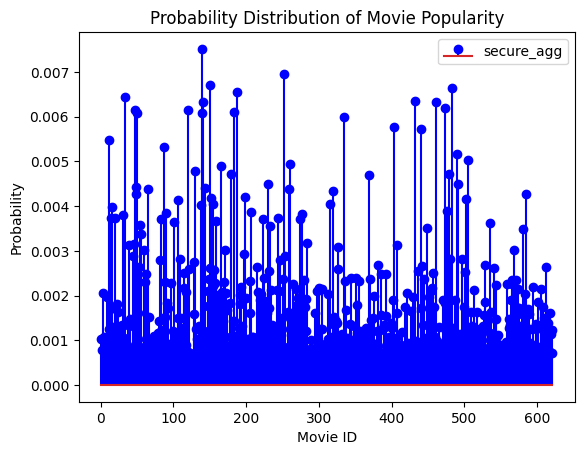

In [ ]:
import matplotlib.pyplot as plt
from VAE import *
model = VAE().to("cuda:0")
model.load_state_dict(w)
temp = [0 for i in range(len(u_cnt1[0]))]
for i in range(100000):
    t1 = model.sample().tolist()[0]
    for i in range(len(temp)):
        temp[i]+=t1[i]
for i in range(len(temp)):
    temp[i]/=100000
plt.stem([i+1 for i in range(len(temp))],temp,'b',label = 'without_load')
plt.title("Probability Distribution of Movie Popularity")
plt.xlabel("Movie ID")
plt.ylabel("Probability")

plt.legend(loc ='best')